# Score gene locus

In [2]:
import os
import crested
import anndata
import keras
import matplotlib

# Set the font type to ensure text is saved as whole words
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed
matplotlib.rcParams['figure.dpi'] = 400

In [10]:
data_files_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data"
adata_path_hydrop = os.path.join(data_files_root, "anndatas/hydrop_allcells_allreads/normalized_specific.h5ad")
model_folder_hydrop = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned/hydrop_allcells_allreads"
bigwigs_folder = os.path.join(data_files_root, "bigwigs/hydrop_allcells_allreads")

genome_path = "../../../../../../../data/genomes/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa"

In [5]:
# load all models
models_hydropv2 = [keras.models.load_model(os.path.join(model_folder_hydrop, model_path), compile=False) for model_path in os.listdir(model_folder_hydrop)]

assert len(models_hydropv2) == 10 # 10 folds

I0000 00:00:1753778422.771078 2200768 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0


In [6]:
adata_hydropv2 = anndata.read_h5ad(
    adata_path_hydrop
)

In [7]:
genome = crested.Genome(genome_path, name="mm10")
crested.register_genome(genome)

2025-07-29T10:40:29.166927+0200 INFO Genome mm10 registered.


## Chys3 Gene Locus

In [9]:
chrom = "chr18" # Unseen chromosome
start= 59175401
end= 59410446

cell_type = "L6_CT"
class_idx = list(adata_hydropv2.obs_names).index(cell_type)

upstream=50000
downstream=25000

strand= '+'

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=models_hydropv2, # average score over all models
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

I0000 00:00:1753778510.499869 2201411 service.cc:152] XLA service 0x7f88d400d040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753778510.499915 2201411 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-07-29 10:41:50.528933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753778510.621754 2201411 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-29 10:41:51.298572: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 4 bytes spill stores, 4 bytes spill loads

2025-07-29 10:41:54.007835: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv.10 = (f32[256,512,1,1055]{3,2,1,0}, u8[0]{0}) custom-call(f32[25

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

I0000 00:00:1753778529.069847 2201411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


In [13]:
bigwig = bigwigs_folder +'/'+ cell_type + "___HyDrop_v2.fragments.bw"

values = (
    crested.utils.read_bigwig_region(
        bigwig, (chrom, start - upstream, end + downstream)
    )
    if strand == "+"
    else crested.utils.read_bigwig_region(
        bigwig, (chrom, start - downstream, end + upstream)
    )
)
bw_values = values[0]
midpoints = values[1]

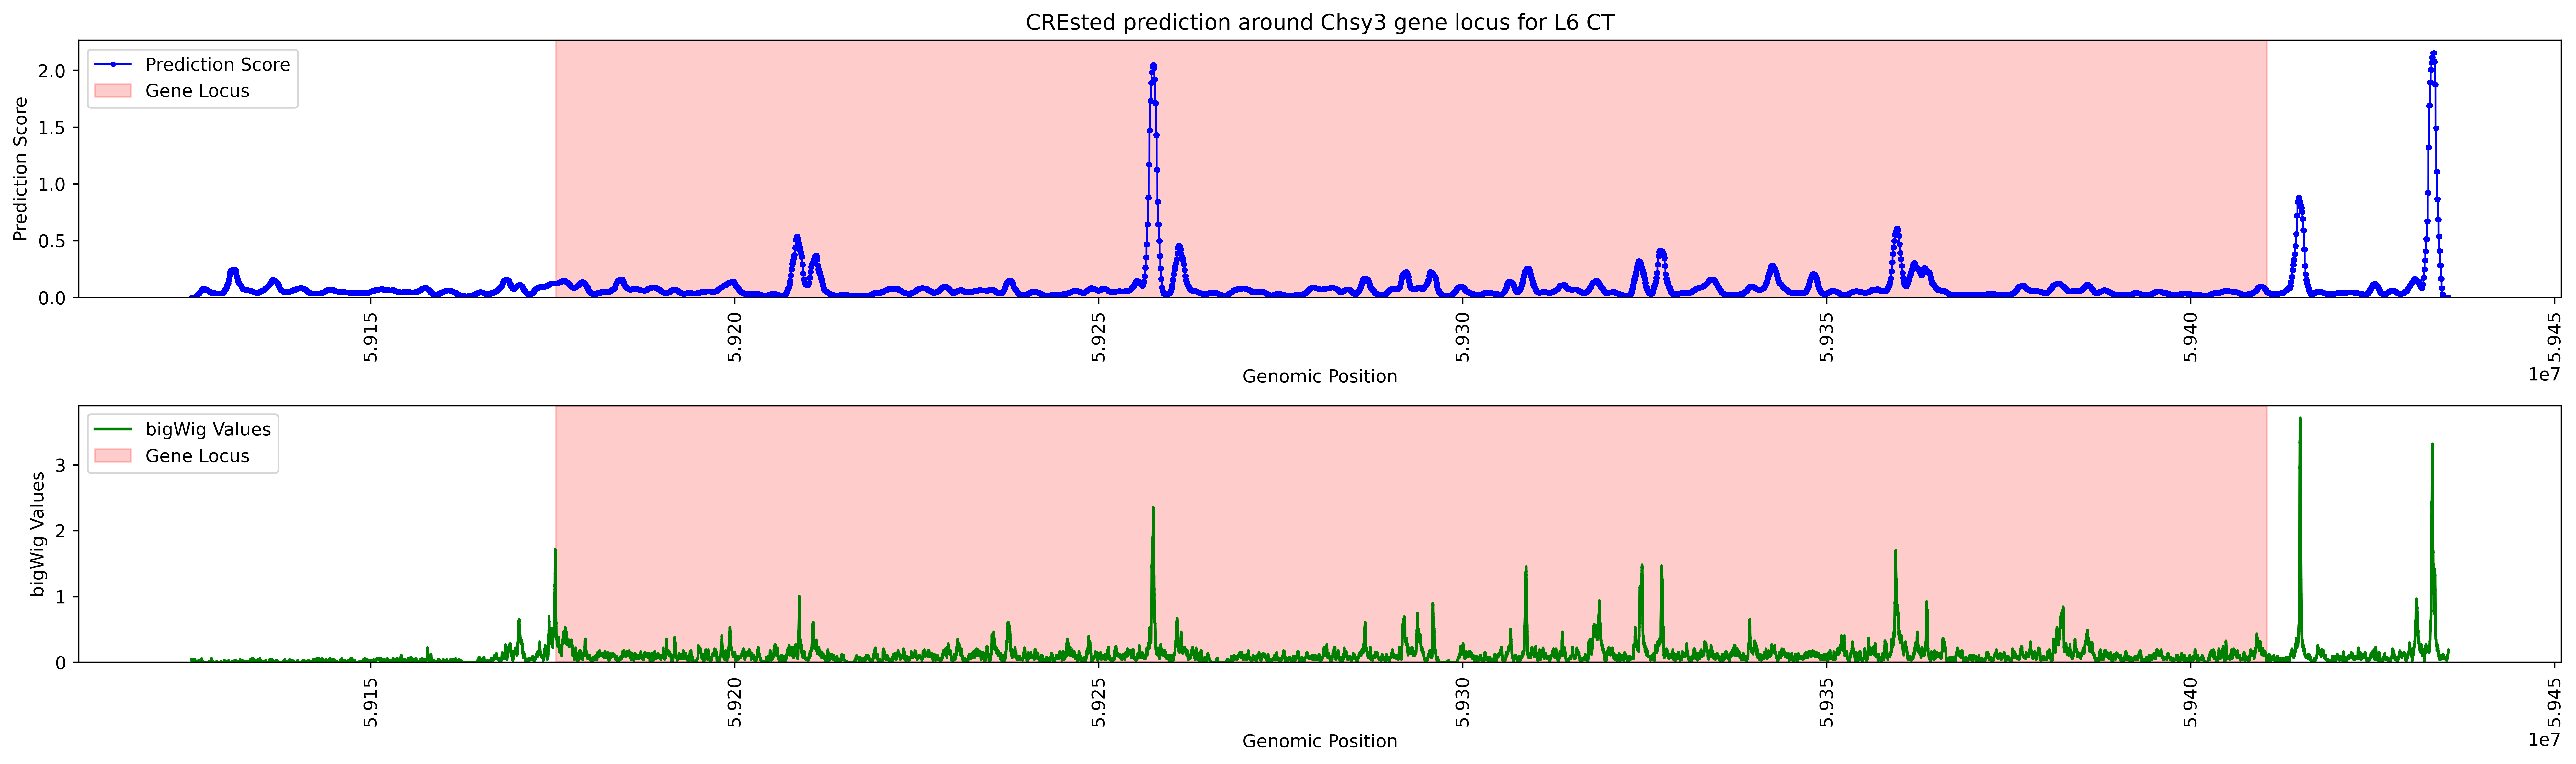

In [20]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Chsy3 gene locus for L6 CT",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    grid=False,
    figsize=(20, 6),
    marker_size=2,
    line_width=1,
    save_path="../../../plots/locus_scoring_chsy3_l6ct_hydropv2.pdf",
)